In [156]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

In [157]:
df = pd.read_csv(
    "test_data/tnp_trip_96.csv",
    header=None,
    usecols=[15, 16, 18, 19],
    names=["pickup_lat", "pickup_lon", "dropoff_lat", "dropoff_lon"],
    dtype=float
)

In [6]:
print(df)

         pickup_lat  pickup_lon  dropoff_lat  dropoff_lon
0         41.921877  -87.664078    41.942859   -87.717504
1         41.870415  -87.675086    41.879255   -87.642649
2         41.901567  -87.638404    41.979071   -87.903040
3         41.952823  -87.653244    41.912364   -87.675063
4         41.946295  -87.654298    41.943155   -87.640698
...             ...         ...          ...          ...
3714112   41.938666  -87.711211    41.938666   -87.711211
3714113   42.016011  -87.680162          NaN          NaN
3714114   41.762247  -87.732059    41.765330   -87.717207
3714115   41.892196  -87.684289    41.935745   -87.730302
3714116   41.713149  -87.675075    41.741243   -87.551428

[3714117 rows x 4 columns]


In [38]:
def make_gdf(lon_col, lat_col):
    sub = df[[lon_col, lat_col]].dropna()
    geom = [Point(xy) for xy in zip(sub[lon_col], sub[lat_col])]
    g = gpd.GeoDataFrame(sub, geometry=geom, crs="EPSG:4326")
    return g.to_crs(epsg=3857)

gdf_departures = make_gdf("pickup_lon",  "pickup_lat")
gdf_arrivals   = make_gdf("dropoff_lon", "dropoff_lat")

xs_dep, ys_dep = gdf_departures.geometry.x.values, gdf_departures.geometry.y.values
xs_arr, ys_arr = gdf_arrivals.geometry.x.values,   gdf_arrivals.geometry.y.values

In [89]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Load the CSV file
areas_df = pd.read_csv("test_data/CommAreas_20250422.csv")

# Convert WKT strings to shapely geometries
areas_df["geometry"] = areas_df["the_geom"].apply(wkt.loads)

# Create a GeoDataFrame and set CRS to WGS84 (EPSG:4326)
areas_gdf = gpd.GeoDataFrame(areas_df, geometry="geometry", crs="EPSG:4326")

# Reproject to Web Mercator (for alignment with trips and basemaps)
areas_gdf = areas_gdf.to_crs("EPSG:3857")


In [90]:
# Spatial join pickups and dropoffs to community areas
dep_with_area = gpd.sjoin(gdf_departures, areas_gdf, how="inner", predicate="within")
arr_with_area = gpd.sjoin(gdf_arrivals,   areas_gdf, how="inner", predicate="within")

In [155]:
# Group by the 'COMMUNITY' column
dep_counts = dep_with_area["COMMUNITY"].value_counts().rename("departures")
arr_counts = arr_with_area["COMMUNITY"].value_counts().rename("arrivals")

# Combine counts and join to areas
counts = pd.concat([dep_counts, arr_counts], axis=1).fillna(0)
areas_summary = areas_gdf.set_index("COMMUNITY").join(counts)
cols_to_drop = [
    'the_geom', 'PERIMETER', 'AREA', 'COMAREA_', 'COMAREA_ID',
    'AREA_NUMBE', 'AREA_NUM_1', 'SHAPE_AREA', 'SHAPE_LEN'
]
areas_summary = areas_summary.drop(columns=cols_to_drop, errors='ignore')
areas_summary.drop(columns="geometry").head(10)

,departures,arrivals
COMMUNITY,,
DOUGLAS,23748,24308
OAKLAND,5656,5427
FULLER PARK,3724,3543
GRAND BOULEVARD,25156,23856
KENWOOD,18608,19653
LINCOLN SQUARE,36978,36790
WASHINGTON PARK,14360,13875
HYDE PARK,90242,91895
WOODLAWN,36462,37584


In [149]:
def plot_choropleth_with_labels(gdf, column, title, cmap):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot the colored polygons
    gdf.plot(column=column,
             cmap=cmap,
             legend=True,
             edgecolor="white",
             ax=ax)

    # Custom label overrides
    label_map = {
        "ENGLEWOOD": "ENGLE-\nWOOD",
        "WEST ENGLEWOOD": "WEST\nENGLE-\nWOOD",
        "GRAND BOULEVARD": "GRAND\nBOULE-\nVARD",
        "BRIDGEPORT": "BRIDGE-\nPORT"
    }

    # Add labels at polygon centroids (vertically stacked or custom)
    for idx, row in gdf.iterrows():
        if row[column] > 0:
            x, y = row.geometry.representative_point().coords[0]
            label = label_map.get(idx, "\n".join(idx.split()))
            ax.text(x, y, label, fontsize=5.5, ha="center", va="center", color="black")

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

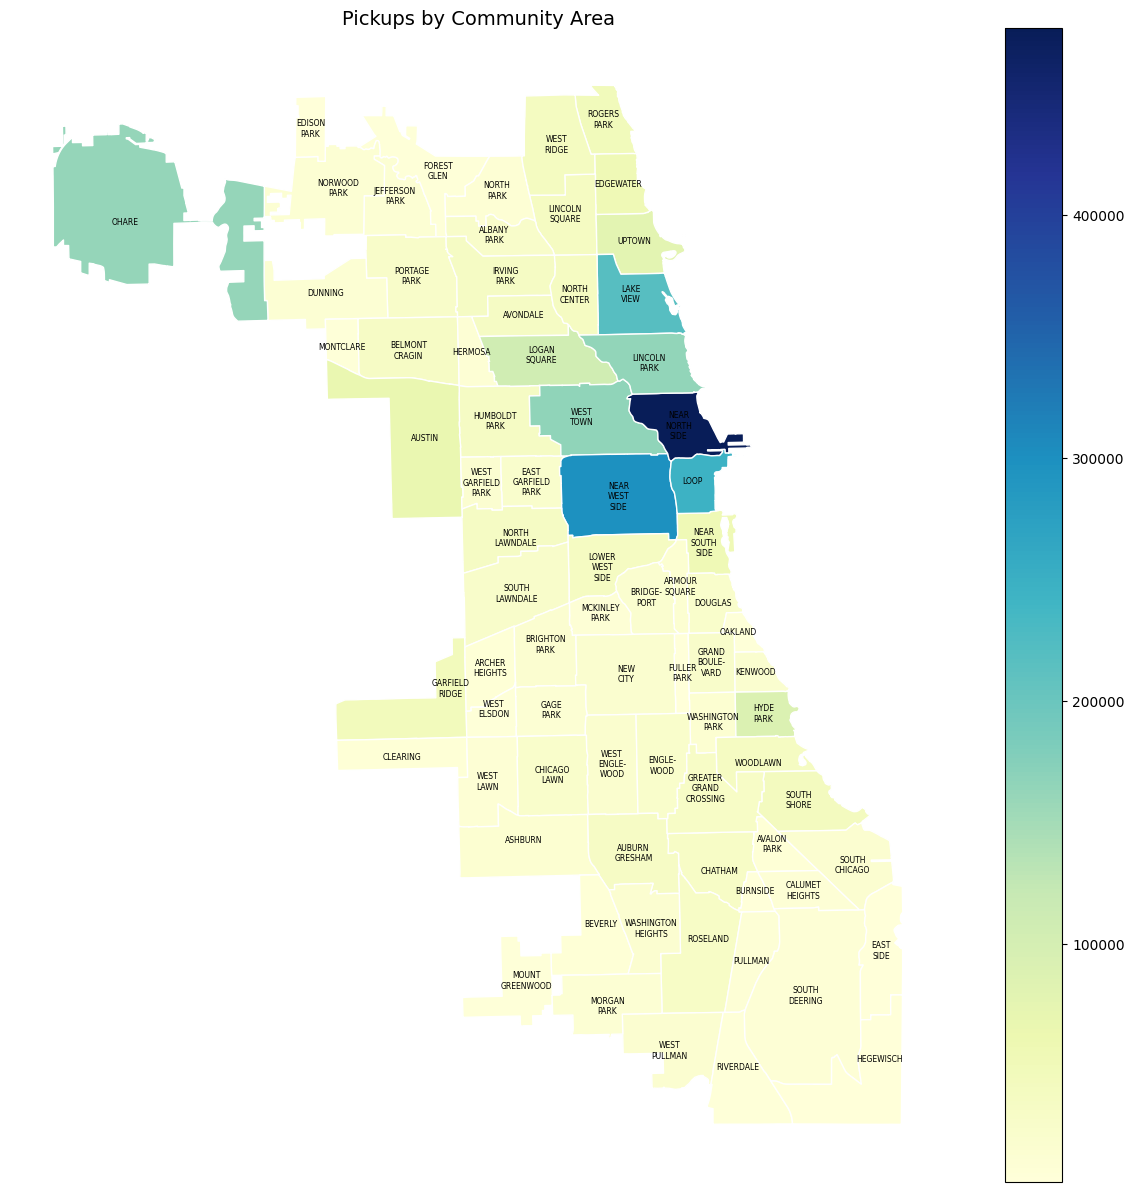

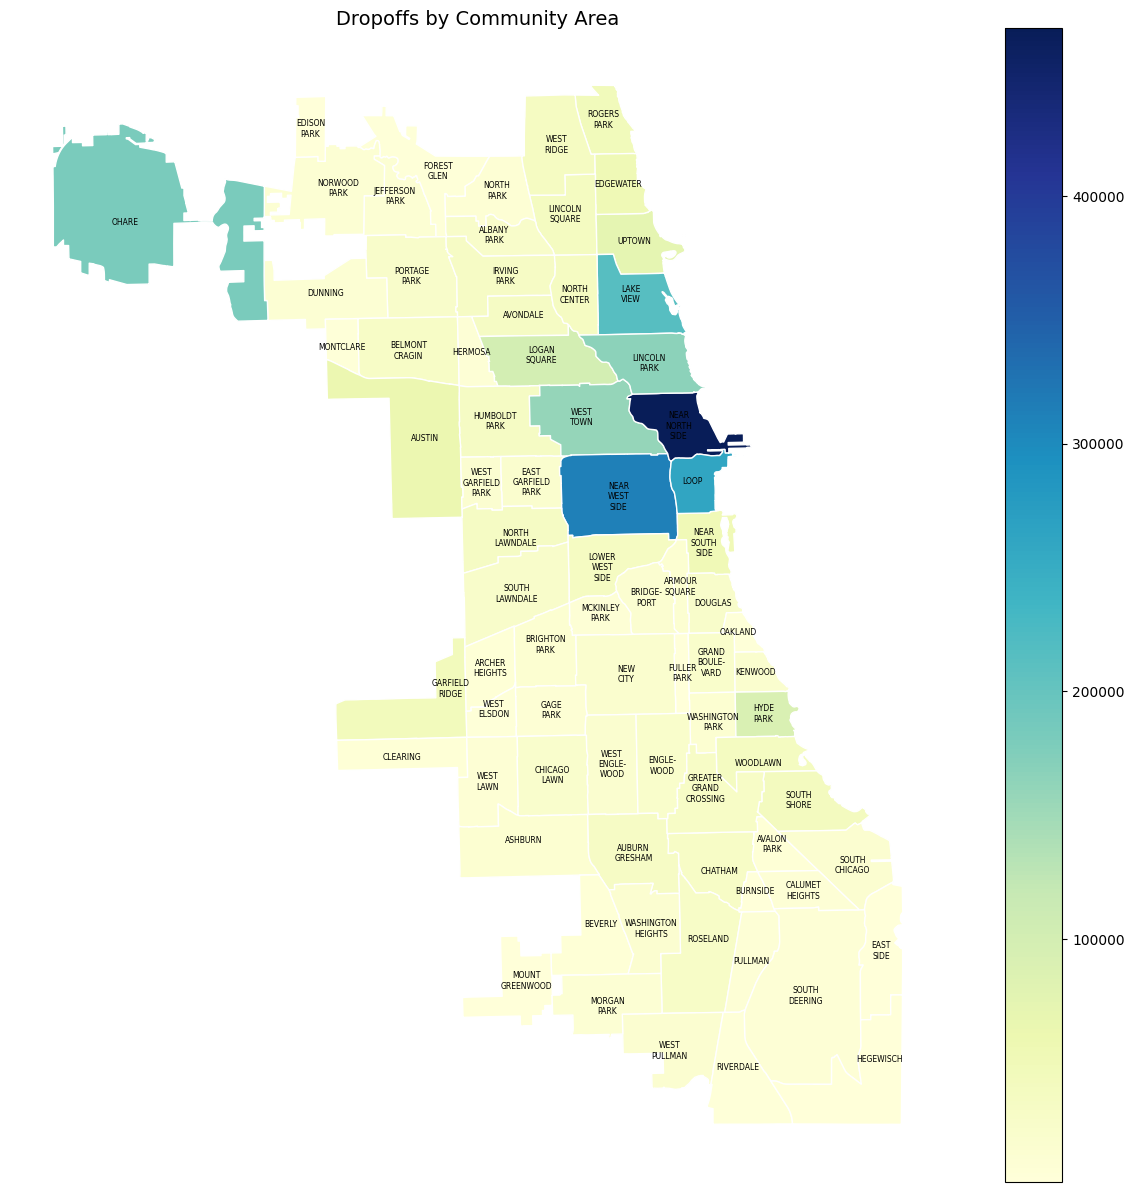

In [150]:
plot_choropleth_with_labels(areas_summary, "departures",
                            "Pickups by Community Area", cmap="YlGnBu")

plot_choropleth_with_labels(areas_summary, "arrivals",
                            "Dropoffs by Community Area", cmap="YlGnBu")


In [151]:
def plot_difference_map_with_labels(gdf,
                                    col1="departures",
                                    col2="arrivals",
                                    title="Pickup vs Dropoff Balance"):

    # 1. Compute difference
    gdf["diff"] = gdf[col1] - gdf[col2]

    # 2. Symmetric color scale around 0
    vmax = 2000

    # 3. Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    gdf.plot(column="diff",
             cmap="bwr",  # blue for dropoff-heavy, red for pickup-heavy
             legend=True,
             edgecolor="white",
             vmin=-vmax,
             vmax=vmax,
             ax=ax)

    # 4. Custom label overrides
    label_map = {
        "ENGLEWOOD": "ENGLE-\nWOOD",
        "WEST ENGLEWOOD": "WEST\nENGLE-\nWOOD",
        "GRAND BOULEVARD": "GRAND\nBOULE-\nVARD",
        "BRIDGEPORT": "BRIDGE-\nPORT"
    }

    # 5. Add labels at representative points
    for idx, row in gdf.iterrows():
        if row["diff"] != 0:
            x, y = row.geometry.representative_point().coords[0]
            label = label_map.get(idx, "\n".join(idx.split()))
            ax.text(x, y, label, fontsize=5.5, ha="center", va="center", color="black")

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


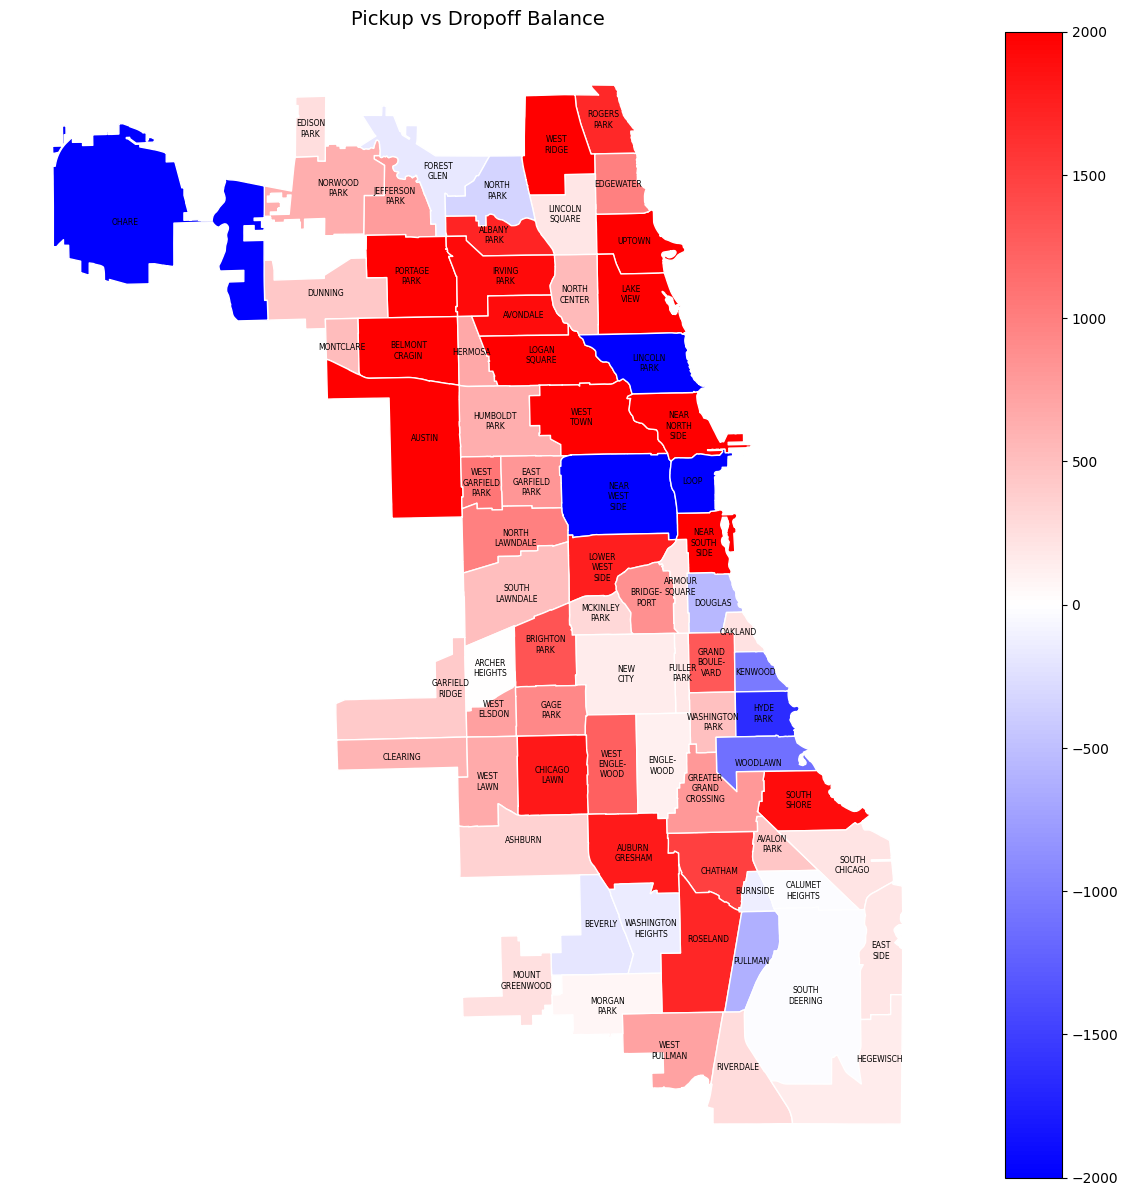

In [144]:
plot_difference_map_with_labels(areas_summary)